# Contents
* Load Dataset
* EDA print samples
* Preprocesss - convert into tensors, train split 
* Create batch size and data loaders
* Move to devices
* Create model
* Create fit function
* Create acuracy evaluate function
* Train
* Print results
* Plot curves and predictions

# Imports

In [ ]:
import torch
import torchvision
from  torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import os
import tarfile
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

Using downloaded and verified file: ./cifar10.tgz


In [ ]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

In [ ]:
os.listdir('./data/cifar10')

['test', 'train']

# PreProcess

In [ ]:
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32,padding_mode='reflect'),
                        tt.RandomHorizontalFlip(), 
                        tt.ToTensor(),
                       tt.Normalize(*stats,inplace=True)])
valid_tfms = tt.Compose( [tt.ToTensor(),
                       tt.Normalize(*stats,inplace=True)])

In [ ]:
train_ds = ImageFolder('./data/cifar10/train',train_tfms)
valid_ds = ImageFolder('./data/cifar10/test',valid_tfms)

In [ ]:
train_ds.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [ ]:
# Show images from dataset
def show_image(img,label):
  print("Label is ",train_ds.classes[label])
  plt.imshow(img.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label is  airplane


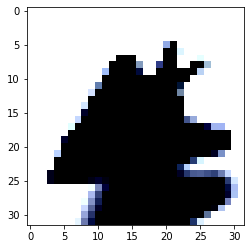

In [ ]:
show_image(*train_ds[0])

In [ ]:
# Initializae dataloader with batch size
batch_size = 128
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=False)
valid_dl = DataLoader(valid_ds,batch_size=batch_size,num_workers=4,pin_memory=False)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


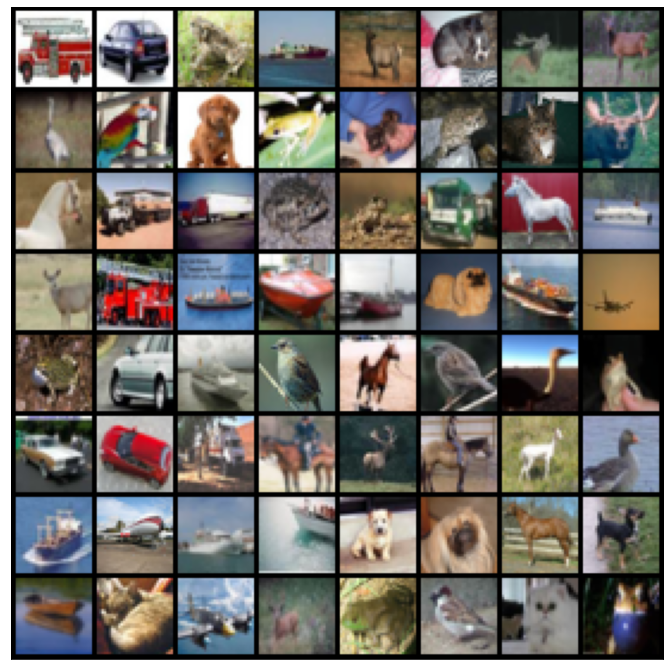

In [ ]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1, 2, 0).clamp(0,1))
        break
show_batch(train_dl)

In [ ]:
# Print the batch shape
for imgs,labels in train_dl:
  print(imgs.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([128, 3, 32, 32])


# GPU Move

In [ ]:
# Create the GPU setup required
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else: 
    return torch.device('cpu')

def to_device(data,device):
  if isinstance(data, (list,tuple)):
    return [to_device(x,device) for x in data]
  return data.to(device, non_blocking = True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
# Check current device
device = get_default_device()
device

device(type='cuda')

In [ ]:
# Move dataset/ dataloaders and model to GPU
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)


# Model 

Create a model class with all the required functions like train step, val step, etc

In [ ]:
# A model class inherits nn.Module class
class ImageClassificationBase(torch.nn.Module):

  def training_step(self,batch):
    imgs,labels = batch
    out = self(imgs)
    loss = F.cross_entropy(out,labels)
    return loss

  def validation_step(self,batch):
    
    imgs,labels = batch
    out = self(imgs)
    loss = F.cross_entropy(out,labels)
    acc = accuracy(out,labels)
    return {'accuracy':acc,'val_loss' : loss.detach()}

  def validation_epoch_end(self,val_dl):
    batch_loss = [self.validation_step((xb,yb))['val_loss'] for xb,yb in val_dl ]
    epoch_loss = torch.stack(batch_loss).mean()
    batch_acc = [self.validation_step((xb,yb))['accuracy'] for xb,yb in val_dl]
    epoch_acc = torch.stack(batch_acc).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
    epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
         
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
    
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
# Check the model 
model = to_device(ResNet9(3, 10), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

In [ ]:
# Run a sample prediction to check outputs
for images, labels in valid_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([ 3.2996, -0.7276, -0.2058, -0.9759,  1.3065, -1.0806, -0.6854,  1.1575,
         0.6366,  3.0260], device='cuda:0', grad_fn=<SelectBackward>)


# Training

In [ ]:
@torch.no_grad()
# def evaluate(model, val_loader):
#     model.eval()
#     outputs = [model.validation_step(batch) for batch in val_loader]
#     return model.validation_epoch_end(outputs)
def evaluate(model, val_loader):
    model.eval()
    outputs = model.validation_epoch_end(val_loader)
    return outputs

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.12124209105968475, 'val_loss': 2.3011319637298584}]

In [ ]:
# Initialize Hyperparameters
num_epochs = 20
opt_func = torch.optim.Adam
lr = 0.005

In [ ]:
%%time
history = fit_one_cycle( num_epochs, lr, model, train_dl, valid_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], last_lr: 0.00104, train_loss: 1.5556, val_loss: 1.1460, val_acc: 0.5913
Epoch [1], last_lr: 0.00280, train_loss: 1.1091, val_loss: 1.0147, val_acc: 0.6518
Epoch [2], last_lr: 0.00520, train_loss: 1.0295, val_loss: 1.0041, val_acc: 0.6811
Epoch [3], last_lr: 0.00760, train_loss: 0.9017, val_loss: 1.4019, val_acc: 0.6200
Epoch [4], last_lr: 0.00936, train_loss: 0.7506, val_loss: 0.9809, val_acc: 0.7100
Epoch [5], last_lr: 0.01000, train_loss: 0.6427, val_loss: 0.8293, val_acc: 0.7536
Epoch [6], last_lr: 0.00987, train_loss: 0.5549, val_loss: 0.7457, val_acc: 0.7851
Epoch [7], last_lr: 0.00950, train_loss: 0.4906, val_loss: 0.6390, val_acc: 0.8131
Epoch [8], last_lr: 0.00891, train_loss: 0.4380, val_loss: 0.5047, val_acc: 0.8428
Epoch [9], last_lr: 0.00812, train_loss: 0.3780, val_loss: 0.6790, val_acc: 0.8051
Epoch [10], last_lr: 0.00717, train_loss: 0.3291, val_loss: 0.7452, val_acc: 0.7996
Epoch [11], last_lr: 0.00611, train_loss: 0.2803, val_loss: 0.5377, val_acc: 0.8496
Ep

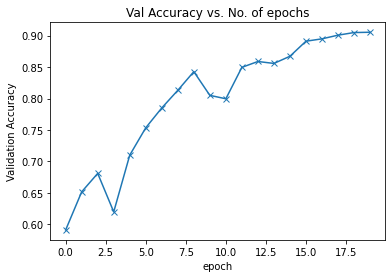

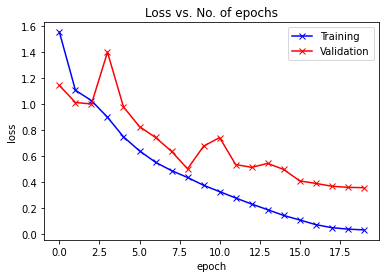

In [ ]:
# Plot the accuracy and loss curve
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.figure()
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Val Accuracy vs. No. of epochs');


def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.figure()
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

plot_accuracies(history)
plot_losses(history)

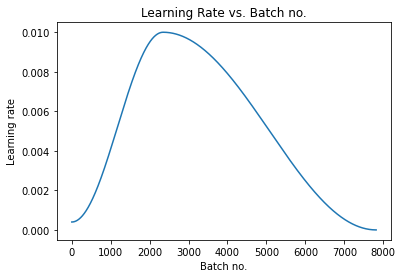

In [ ]:
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.')

plot_lrs(history)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: airplane , Predicted: airplane
Label: airplane , Predicted: airplane
Label: frog , Predicted: frog


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.9053599834442139, 'val_loss': 0.35940349102020264}

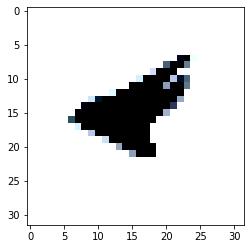

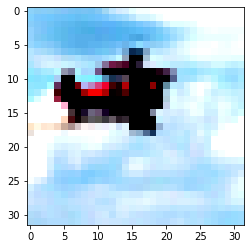

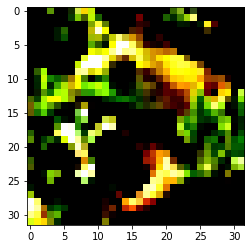

In [ ]:
# Check the performance on test set
# test_dataset = ImageFolder('./data/cifar10/test', transform=train_tfms())

def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return train_ds.classes[preds[0].item()]

plt.figure()
img, label = valid_ds[2]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

plt.figure()
img, label = valid_ds[102]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

plt.figure()
img, label = valid_ds[6159]
plt.imshow(img.permute(1, 2, 0))
print('Label:', train_ds.classes[label], ', Predicted:', predict_image(img, model))

result = evaluate(model, valid_dl)
result

# Conclusion
* The model performs with ~ 90% accuracy. 
* With higher epochs and deeper architecture, the model can perform even better